In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.io import loadmat
from scipy import io
import scipy.signal
import matplotlib.pyplot as plt
import scipy.fftpack
import IPython

## Understanding the data and pre-processing

Load the Audio and HRTF data file

In [2]:
## Loading audio file
sample_rate, data = wavfile.read('helicopter.wav')

In [3]:
## Loading HRTF data file
read_mat = loadmat('large_pinna_final.mat')

HRTF data contains left and right, which represents the HRTF data contained for left ear and right ear respectively.

In [4]:
left = read_mat.get('left')   #storing left array of data
right = read_mat.get('right') #storing right array of data

To understand how we are Pre-processing the data, we are going to take data at 10 degrees from left. Our data base for the HRIR LEFT and HRIR RIGHT have 200×72 matrix form.
The 72 coloums, which is taken for 360 degrees at a difference of 5 degrees (i.e. 0, 5, 10, ..., 355)

$ \textbf{The diagram below shows the index number corresponded the angle we are going to implement}$

![title](img/data_representation.png)

So, index 16 takes the data for angle = 10 degrees

In [5]:
left_10 = left[:, 16]
right_10 = right[:, 16]

In [6]:
mat_data_length = len(right[:, 0])

In [7]:
mat_data_length

200

The audio signal is sampled at $44100$ Hz.
We are taking signal of $1$ Second  length

In [8]:
audio_sample_frequency = 44100 #in Hz
audio_length = 1 #sec
audio_sample_length = audio_sample_frequency * audio_length

To perform the convolution and not to loss any data during that process, we will zero pad the signal.

We are zero padding the mat file, because ...........

In [9]:
left_final = np.zeros(audio_sample_length + mat_data_length)
right_final = np.zeros(audio_sample_length + mat_data_length)

In [10]:
left_data = np.zeros(audio_sample_length + mat_data_length)
pad_data=np.zeros(audio_sample_length)
left_data=np.append(left_10, pad_data) #appending zeros in the end
left_data_fft=scipy.fftpack.fft(left_data) #fast fourier transfer
left_data_fft_shift=np.real(np.fft.ifftshift(left_data_fft)) #swaping to get the desired frequency response

This is the visualization of $ \textbf{left}$ data in $ \textbf{Frequency Domain}$.

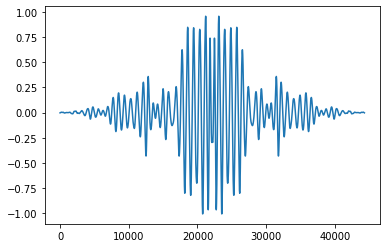

In [11]:
plt.plot(range(len(left_data_fft_shift)),left_data_fft_shift)
plt.show()

Similarly, we are going to get frequency representation of $ \textbf{Right}$ data

In [12]:
right_data = np.zeros(audio_sample_length + mat_data_length, np.int16)
pad_right=np.zeros(audio_sample_length, np.int16) #zeros to make it of lenght: n+p-1
right_data=np.append(right_10, pad_right) #appending zeros in the end
right_data_fft=scipy.fftpack.fft(right_data) #fast fourier transfer
right_data_fft_shift=np.real(np.fft.ifftshift(right_data_fft)) #swaping to get the desired frequency response

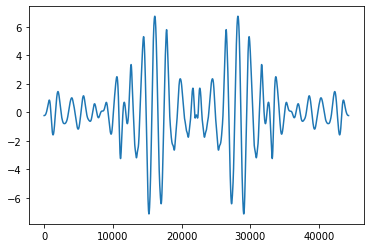

In [13]:
plt.plot(range(len(right_data_fft_shift)),right_data_fft_shift)
plt.show()

Now, we are going to get Frequency Domain representation of $ \textbf{Audio}$ signal

In [14]:
starting_sample_sound = 88200 #after the 2nd second of audio signal
data_test = data[starting_sample_sound: starting_sample_sound + audio_sample_length]
pad_data=np.zeros(mat_data_length, np.int16) #zeros to make it of lenght: n+p-1
data_test=np.append(data_test, pad_data) #appending zeros in the end
data_test_fft=scipy.fftpack.fft(data_test) #fast fourier transfer
data_test_fft_shift=np.real(np.fft.ifftshift(data_test_fft)) #swaping to get the desired frequency response

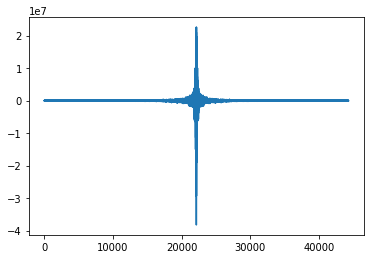

In [15]:
plt.plot(range(len(data_test_fft_shift)),data_test_fft_shift)
plt.show()

$ \textbf{Extraction of valuble data}$

As we can see from the above representation, the frequency components dominate in the middle region. So, these are the frequency components/features of interest. Here we are taking 4000 samples concentrated at the middle

In [16]:
sample_considered = 2000 #taking on both sides of the midian

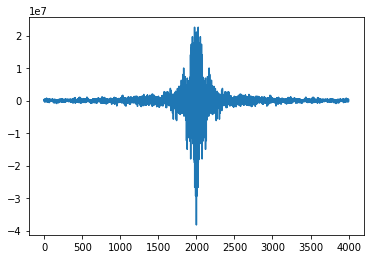

In [17]:
plt.plot(range(len(data_test_fft_shift[22150 - sample_considered:22150 + sample_considered])),data_test_fft_shift[22150 - sample_considered:22150 + sample_considered])
plt.show()

$ \textbf{Convolving the Left and Right data with audio signal}$

The ouput will be the convolved signal for Left and Right ear

In [18]:
freq_left_out=left_data_fft_shift*data_test_fft_shift # multipling in frequency domain
freq_right_out=right_data_fft_shift*data_test_fft_shift # multipling in frequency domain

Visualizing the frequency domain represenatation of Left Ear audio signal.

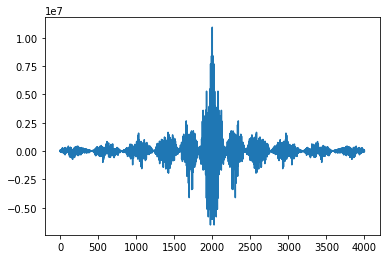

In [19]:
plt.plot(range(len(freq_left_out[22150 - sample_considered:22150 + sample_considered])),freq_left_out[22150 - sample_considered:22150 + sample_considered])
plt.show()

Visualizing the frequency domain represenatation of Right Ear audio signal.

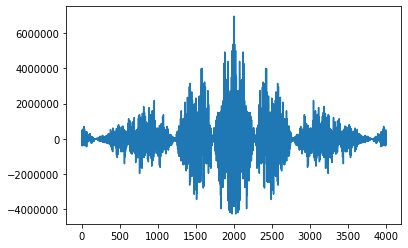

In [20]:
plt.plot(range(len(freq_right_out[22150 - sample_considered: 22150 + sample_considered])),freq_right_out[22150 - sample_considered:22150 + sample_considered])
plt.show()

We are not going to consider the mod of the signal, because the model will not be learn due to high Oscillation in the signal from positive to negative.

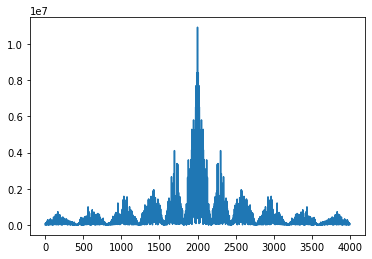

In [21]:
plt.plot(range(len(freq_left_out[22150 - sample_considered:22150 + sample_considered])),np.abs(freq_left_out[22150 - sample_considered:22150 + sample_considered]))
plt.show()

$ \textbf{Downsampling} $

To smoothen the signal and reduce the number of inputs for our model, we will down sample the signal

In [22]:
sample_num = 100

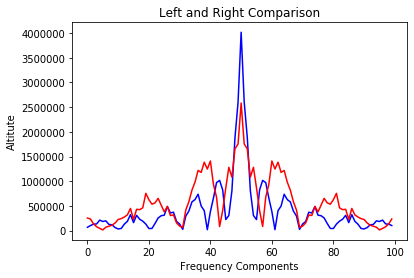

In [23]:
downsampled_left_out = scipy.signal.resample(np.abs(freq_left_out[22150 - sample_considered:22150 + sample_considered]), sample_num, t=None, axis=0, window=None)
downsampled_right_out = scipy.signal.resample(np.abs(freq_right_out[22150 - sample_considered:22150 + sample_considered]), sample_num, t=None, axis=0, window=None)
plt.plot(range(sample_num), downsampled_left_out, color = 'blue', label='Left')
plt.plot(range(sample_num), downsampled_right_out, color = 'red', label='Right')
plt.title('Left and Right Comparison')
plt.xlabel('Frequency Components')
plt.ylabel('Altitute')
plt.show()

Here Blue line is the audio signal's frequency domain representation of what frequencies a human ear precept on the Left ear when the sound source is on left side. In the contrast, the Red is frequency domain representation for Right ear.

$ \textbf{What's the Idea?} $

As we can see from the above graph, when the sound source in on left side, in the middle we can see high peak for left side thats represent the signal strenght is high on high frequencies. While when it comes to low frequencies, right side has more signal strenght than left side. 

What we are going is we are going to take the difference between the left and right ear and train our model on that.

The difference is key to find the direction from which the sound is coming

## Creating Training data

#### Defining the functions

In [24]:
def fft_audio (audio_data, starting_sample_sound, audio_sample_length, mat_data_length):
    data_test = data[starting_sample_sound: starting_sample_sound + audio_sample_length]
    pad_data=np.zeros(mat_data_length) #zeros to make it of lenght: n+p-1
    data_test=np.append(data_test, pad_data) #appending zeros in the end
    data_test_fft=scipy.fftpack.fft(data_test) #fast fourier transfer
    data_test_fft_shift=np.real(np.fft.ifftshift(data_test_fft)) #swaping to get the desired frequency response
    return data_test_fft_shift


In [25]:
def fft_data (audio_sample_length, mat_data_length, left_mat_data, right_mat_data):
    pad_data=np.zeros(audio_sample_length)
    
    left_data = np.zeros(audio_sample_length + mat_data_length)
    left_data=np.append(left_mat_data[i], pad_data) #appending zeros in the end
    left_data_fft=scipy.fftpack.fft(left_data) #fast fourier transfer
    left_data_fft_shift=np.real(np.fft.ifftshift(left_data_fft)) #swaping to get the desired frequency response
    
    right_data = np.zeros(audio_sample_length + mat_data_length, np.int16)
    right_data = np.append(right_mat_data[i], pad_data) #appending zeros in the end
    right_data_fft = scipy.fftpack.fft(right_data) #fast fourier transfer
    right_data_fft_shift = np.real(np.fft.ifftshift(right_data_fft)) #swaping to get the desired frequency
    
    return left_data_fft_shift, right_data_fft_shift


In [26]:
def downsampling (data, samples_number, sample_considered, down_sample_num):
    downsampled_data = np.zeros((samples_number, down_sample_num))
    for i in range (samples_number):
        downsampled_data[i] = scipy.signal.resample(np.abs(data[i][22150 - sample_considered:22150 + sample_considered]), down_sample_num, t=None, axis=0, window=None)
    return downsampled_data


In [27]:
def difference (downsampled_left, downsampled_right, samples_number, down_sample_num):
    difference_data = np.zeros((samples_number, down_sample_num))
    for i in range (samples_number):
        difference_data[i] = downsampled_left[i] - downsampled_right[i]
    return difference_data


In [28]:
def normalize (difference_data, samples_number, down_sample_num):
    maximum = 0
    minimum = 0
    for i in range (samples_number):
        local_maximum = max(difference_data[i])
        local_minimum = min(difference_data[i])
        if (maximum < local_maximum):
            maximum = local_maximum
        if (minimum > local_minimum):
            minimum = local_minimum
    
    normalizied_data = np.zeros((samples_number, down_sample_num))
    for i in range (samples_number):
        normalizied_data[i] = (difference_data[i] - minimum)/(maximum - minimum)
    return normalizied_data


#### Creating the training data

In the mat file, the data is given for the front source at column index 0

We are gonna train out MLP model on $ \textbf{0, 45, 90, 135 and 180}$ degrees starting from left side.

![title](img/Train_area.png)

In [29]:
audio_sample_frequency = 44100 #in Hz
audio_length = 1 #sec
audio_sample_length = audio_sample_frequency * audio_length
samples_number = 5
starting_time = 2
starting_sample_sound = starting_time * audio_sample_frequency

In [30]:
left_mat_data = np.zeros((samples_number, mat_data_length))
right_mat_data = np.zeros((samples_number, mat_data_length))

In [31]:
left_mat_data[0] = left[:, 18]
left_mat_data[1] = left[:, 9]
left_mat_data[2] = left[:, 0]
left_mat_data[3] = left[:, 63]
left_mat_data[4] = left[:, 54]
right_mat_data[0] = right[:, 18]
right_mat_data[1] = right[:, 9]
right_mat_data[2] = right[:, 0]
right_mat_data[3] = right[:, 63]
right_mat_data[4] = right[:, 54]

In [32]:
audio_signal_fft = fft_audio (data, starting_sample_sound, audio_sample_length, mat_data_length) #getting the fourier tranform of audio signal

In [33]:
left_raw = np.zeros((samples_number, audio_sample_length + mat_data_length))
right_raw = np.zeros((samples_number, audio_sample_length + mat_data_length))
for i in range (samples_number):
    left_data_fft_shift, right_data_fft_shift = fft_data (audio_sample_length, mat_data_length, left_mat_data, right_mat_data)
    left_raw[i] = left_data_fft_shift*audio_signal_fft # multipling in frequency domain
    right_raw[i] = right_data_fft_shift*audio_signal_fft # multipling in frequency domain

#### Down-Sampling

The convolved signal has $3000 samples. So, to reduce the sample size to the size where we are taking the samples that are necessary and then smoothening the signal

In [34]:
down_sample_num = 150
sample_considered = 3000 #taking on both sides of the midian
downsampled_left = downsampling (left_raw, samples_number, sample_considered, down_sample_num)
downsampled_right = downsampling (right_raw, samples_number, sample_considered, down_sample_num)

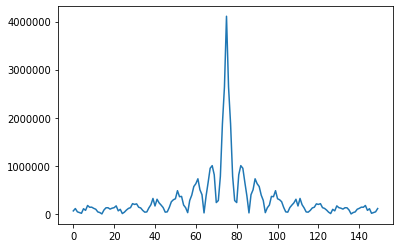

In [35]:
plt.plot(range(down_sample_num), downsampled_left[0])
plt.show()

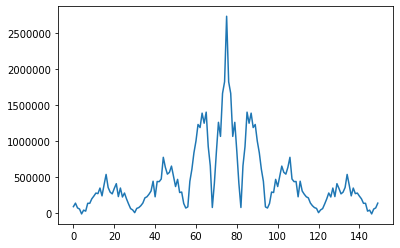

In [36]:
plt.plot(range(down_sample_num), downsampled_right[0])
plt.show()

#### Difference between Left and Right

We are going too the difference between sound received at left and right ear

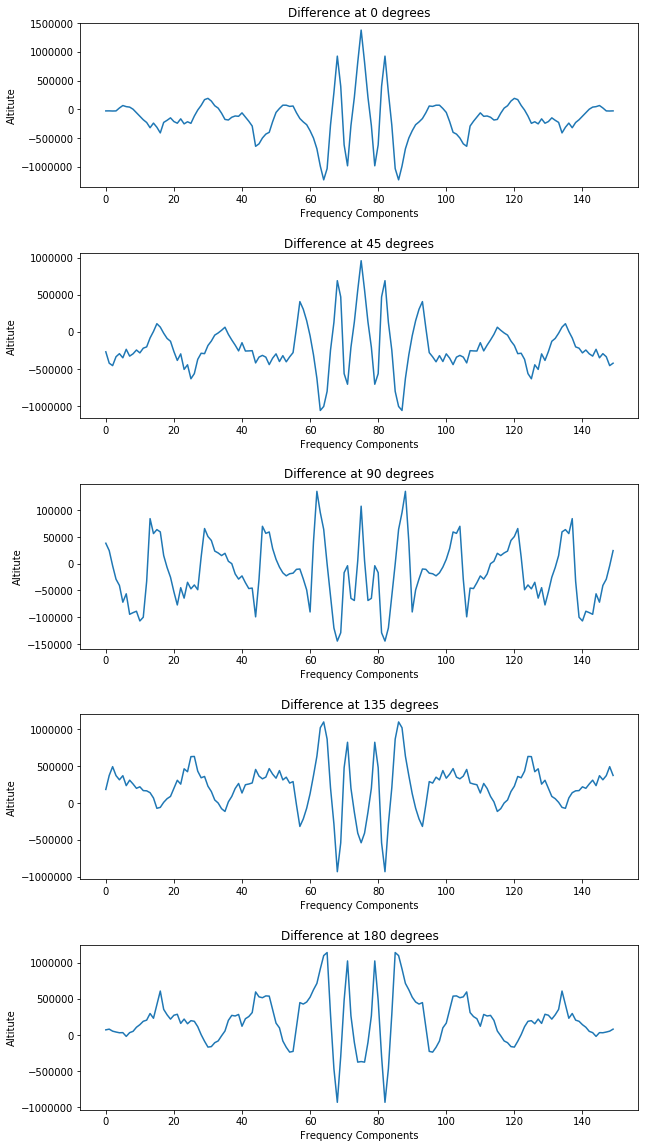

In [37]:
difference_data = difference (downsampled_left, downsampled_right, samples_number, down_sample_num)
# Visualization of data at different angles
fig = plt.figure(figsize=(10, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
angle = 0
for i in range (samples_number):
    string = 'Difference at '+ str(angle) +' degrees'
    plt.subplot(5,1,i+1)
    plt.plot(range(down_sample_num), difference_data[i])
    plt.title(string)
    plt.xlabel('Frequency Components')
    plt.ylabel('Altitute')
    angle = angle +45
plt.show()

#### Normalization

We are normalizing the data between [0,1]

In [38]:
normalizied_difference_data = normalize (difference_data, samples_number, down_sample_num)

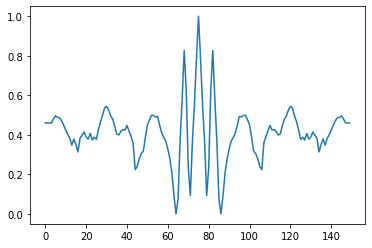

In [39]:
plt.plot(range(down_sample_num), normalizied_difference_data[0])
plt.show()

## Training the Model

The normalized data is our input data to the model. 
Here we are using Multi-layer Preceptron to train our model.

In [40]:
y = np.identity(5)

In [41]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(50), max_iter=10000)
MLP.fit(normalizied_difference_data, y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=50, learning_rate='constant',
              learning_rate_init=0.001, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

## Test Data

#### Creating the test data

For testing we are going to take the different audio file.

In [42]:
## Loading audio file
sample_rate, test_data = wavfile.read('multiphonic.wav')

In [43]:
audio_sample_frequency = 44100 #in Hz
audio_length = 1 #sec
audio_sample_length = audio_sample_frequency * audio_length
starting_time = 10
starting_sample_sound = starting_time * audio_sample_frequency

In [44]:
left_mat_data = np.zeros((samples_number, mat_data_length))
right_mat_data = np.zeros((samples_number, mat_data_length))

In [45]:
# test_samples_number = 5
# left_mat_data[0] = left[:, 18]
# left_mat_data[1] = left[:, 9]
# left_mat_data[2] = left[:, 0]
# left_mat_data[3] = left[:, 63]
# left_mat_data[4] = left[:, 54]
# right_mat_data[0] = right[:, 18]
# right_mat_data[1] = right[:, 9]
# right_mat_data[2] = right[:, 0]
# right_mat_data[3] = right[:, 63]
# right_mat_data[4] = right[:, 54]

Here we are taking 2 directions to test our model.

In [46]:
test_samples_number = 2
left_mat_data[0] = left[:, 63]
left_mat_data[1] = left[:, 18]
right_mat_data[0] = right[:, 63]
right_mat_data[1] = right[:, 18]

In [47]:
test_audio_signal_fft = fft_audio (test_data, starting_sample_sound, audio_sample_length, mat_data_length)
test_left_raw = np.zeros((test_samples_number, audio_sample_length + mat_data_length))
test_right_raw = np.zeros((test_samples_number, audio_sample_length + mat_data_length))
for i in range (test_samples_number):
    test_left_data_fft_shift, test_right_data_fft_shift = fft_data (audio_sample_length, mat_data_length, left_mat_data, right_mat_data)
    test_left_raw[i] = test_left_data_fft_shift * test_audio_signal_fft # multipling in frequency domain
    test_right_raw[i] = test_right_data_fft_shift * test_audio_signal_fft # multipling in frequency domain
test_downsampled_left = downsampling (test_left_raw, test_samples_number, sample_considered, down_sample_num)
test_downsampled_right = downsampling (test_right_raw, test_samples_number, sample_considered, down_sample_num)
test_difference_data = difference (test_downsampled_left, test_downsampled_right, test_samples_number, down_sample_num)
test_normalizied_difference_data = normalize (test_difference_data, test_samples_number, down_sample_num)

### Testing data

In [48]:
output = MLP.predict_proba(test_normalizied_difference_data).argmax(1)+1
print(output)

[4 1]


## Results:

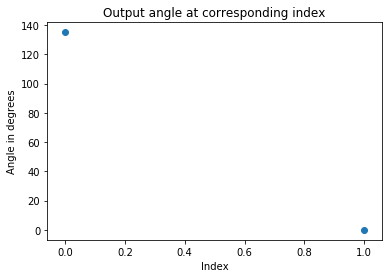

Angle at index [0] is 135 degrees

Angle at index [1] is 0 degrees



In [49]:
angles = 45*output - 45
plt.scatter(range(test_samples_number), angles)
plt.title("Output angle at corresponding index")
plt.xlabel('Index')
plt.ylabel('Angle in degrees')
plt.show()
for i in range (test_samples_number):
    print("Angle at index [" + str(i) + "] is " + str(angles[i]) + " degrees\n")

## Additional :

### Demonstration of HRTF database's effectiveness

Here we are showing the generated audio file for different locations that are at Index [0] is 135 degrees and at Index [1] is 0 degrees

In [55]:
left_final = np.array([])
right_final = np.array([])
left_column=left_mat_data[0]
right_column=right_mat_data[0]

pad_data=np.zeros(200000,np.int16) #length(left_column)+length(audio_data)-1
left_column_to_fft=np.append(left_column,pad_data)
right_column_to_fft=np.append(right_column,pad_data)

left_column_fft=scipy.fftpack.fft(left_column_to_fft)
right_column_fft=scipy.fftpack.fft(right_column_to_fft)

audio_data = data[10000:10000+200000]

pad_audio=np.zeros(200,np.int16) #length(left_column)+length(audio_data)-1
audio_to_fft=np.append(audio_data,pad_audio)

audio_fft=scipy.fftpack.fft(audio_to_fft)

left_convolved_fft=left_column_fft*audio_fft
right_convolved_fft=right_column_fft*audio_fft

left_convolved_time=scipy.fftpack.ifft(left_convolved_fft)
right_convolved_time=scipy.fftpack.ifft(right_convolved_fft)

left_final = np.append(left_final,left_convolved_time)
right_final = np.append(right_final,right_convolved_time)
  
output_data=np.transpose(np.vstack((right_final, left_final)))      
int_output_data = np.int16(output_data)
scipy.io.wavfile.write('Audio at Index-0.wav', sample_rate, int_output_data)

C:\Users\gshar\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


In [56]:
IPython.display.Audio("Audio at Index-0.wav", autoplay=True)

In [57]:
left_final = np.array([])
right_final = np.array([])
left_column=left_mat_data[1]
right_column=right_mat_data[1]

pad_data=np.zeros(200000,np.int16) #length(left_column)+length(audio_data)-1
left_column_to_fft=np.append(left_column,pad_data)
right_column_to_fft=np.append(right_column,pad_data)

left_column_fft=scipy.fftpack.fft(left_column_to_fft)
right_column_fft=scipy.fftpack.fft(right_column_to_fft)

audio_data = data[10000:10000+200000]

pad_audio=np.zeros(200,np.int16) #length(left_column)+length(audio_data)-1
audio_to_fft=np.append(audio_data,pad_audio)

audio_fft=scipy.fftpack.fft(audio_to_fft)

left_convolved_fft=left_column_fft*audio_fft
right_convolved_fft=right_column_fft*audio_fft

left_convolved_time=scipy.fftpack.ifft(left_convolved_fft)
right_convolved_time=scipy.fftpack.ifft(right_convolved_fft)

left_final = np.append(left_final,left_convolved_time)
right_final = np.append(right_final,right_convolved_time)
    
output_data=np.transpose(np.vstack((right_final, left_final)))      
int_output_data = np.int16(output_data)   
scipy.io.wavfile.write('Audio at Index-1.wav', sample_rate, int_output_data)

C:\Users\gshar\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\gshar\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


In [58]:
IPython.display.Audio("Audio at Index-1.wav", autoplay=True)